In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from scipy.io import loadmat, savemat
from skimage.measure import block_reduce
from skimage.registration import phase_cross_correlation

from module import _fft2, _ifft2, Network, PhaseRetrieval

In [2]:
def find_center(input):
    input_T = np.rot90(input, 2)
    shift, _, _ = phase_cross_correlation(input, input_T,
                                          reference_mask=~np.isnan(input),
                                          moving_mask=~np.isnan(input_T),
                                          upsample_factor=1, return_error='always')
    
    dcen = np.fix(shift / 2).astype(int)
    return dcen

def prepare_data(input, bin=None):
    sz = input.shape
    print(f'Input size = {sz}')
    
    if bin is not None:
        pad_width = []
        for i in range(2):
            if sz[i] % bin != 0:
                d = bin - sz[i] % bin
                pad_width.append((d - d // 2, d // 2))
            else:
                pad_width.append((0, 0))
        input = np.pad(input, pad_width, 'constant', constant_values=np.nan)
        input = block_reduce(input, bin, np.sum)
        
        print(f'Binning by {bin}... Input size = {sz} → {input.shape}')
        sz = input.shape
    
    dcen = find_center(input)
    print(f'Center deviation = {dcen}')
    pi = max(0, 512 - sz[0]) + abs(dcen[0]) * 2
    pj = max(0, 512 - sz[1]) + abs(dcen[1]) * 2
    input = np.pad(input, ((pi - pi // 2, pi // 2), (pj - pj // 2, pj // 2)),
                   'constant', constant_values=np.nan)
    
    sz = input.shape
    input = input[sz[0] // 2 - 256 + dcen[0]:sz[0] // 2 + 256 + dcen[0],
                  sz[1] // 2 - 256 + dcen[1]:sz[1] // 2 + 256 + dcen[1]]
    
    mask = ~np.isnan(input)
    input[~mask] = 0
    
    input = torch.from_numpy(input).to(torch.float32)
    mask = torch.from_numpy(mask).to(torch.bool)
    
    input = input[None, None, :, :]
    mask = mask[None, None, :, :]
    
    print(f'Final input size = {input.shape}')
    
    return input, mask


def align_obj_cen(output):
    cen = torch.mean(torch.nonzero(output > output.max() * 0.01).to(torch.float32), dim=0)[-2:]
    output = torch.roll(output, (32 - cen.to(torch.int64)).tolist(), dims=(-2, -1))
    return output
    

def align_obj(output, target, limit=32):
    N = output.shape[0]

    xcorr = F.conv2d(output.reshape(1, N, 64, 64), target, padding=limit, groups=N).squeeze(0)
    xcorrT = F.conv2d(torch.rot90(output, 2, dims=(-2, -1)).reshape(1, N, 64, 64), target, padding=limit, groups=N).squeeze(0)
    
    vmax = torch.amax(xcorr, dim=(-2, -1))
    vTmax = torch.amax(xcorrT, dim=(-2, -1))

    for i in range(N):
        trg = vTmax[i] > vmax[i]
        if trg:
            output[i, :, :, :] = torch.rot90(output[i], 2, dims=(-2, -1))
            dpos = limit - torch.nonzero(xcorrT[i] == vTmax[i]).squeeze()
        else:
            dpos = limit - torch.nonzero(xcorr[i] == vmax[i]).squeeze()
            
        # for failure of equality operation
        if dpos.numel() == 0:
            pos = torch.argmax(xcorrT[i] if trg else xcorr[i])
            dpos = limit - torch.stack([pos // 65, pos % 65])

        # for multiple maximal positions
        if len(dpos.shape) > 1:
            dpos = dpos[torch.argmin(torch.sum(torch.abs(dpos), dim=-1))]
            
        output[i, :, :, :] = torch.roll(output[i], dpos.tolist(), dims=(-2, -1))
        
    return output

def refine_by_pr(inputs, masks, outputs, n_iter, param, device, err_out=False):
    N = inputs.shape[0]
    
    quant = outputs.view(N, 1, -1)
    support_r = outputs > torch.quantile(quant, 0.99, dim=2, keepdim=True) * 0.01
    
    output = torch.zeros(N, 1, 64, 64, device=device)
    error = torch.zeros(N, n_iter)
    
    for i in range(N):
        
        input = torch.fft.ifftshift(torch.sqrt(inputs[i:i + 1].clamp(min=0)), dim=(-2, -1))
        support = F.pad(support_r[i:i+1], (224, 224, 224, 224))
        unknown = torch.fft.ifftshift(~masks[i:i + 1], dim=(-2, -1)).to(dtype=torch.float32)
        
        iterator = PhaseRetrieval(input, support, unknown, **param)
        iterator = iterator.to(device)
        
        phi = torch.angle(_fft2(F.pad(outputs[i:i + 1], (224, 224, 224, 224))))
        phi = torch.cos(phi) + 1j * torch.sin(phi)
        phi = torch.fft.ifftshift(phi, dim=(-2, -1)).to(device)
        
        tmpo, tmpe = iterator(n_iter, phi, **param)
        output[i] = tmpo[0, :, 224:-224, 224:-224]
        error[i] = tmpe[0, :]
        
    if err_out:
        return output, error
    else:
        return output

In [3]:
# phase retrieval arguments
param_r = {
    'algorithm' : 'GPS-R', # [HIO, RAAR, gRAAR, dRAAR, GPS-R, GPS-F, dpGPS-R, dpGPS-F]
    'error' : 'R', # [R, NLL]
    'shrinkwrap' : False, # [True, False]
    
    # common parameters of GPS, dpGPS
    'sigma' : (0, 0.1, 0.4, 1), # parameter for relaxing magnitude constraint
    'alpha_count' : 5, # number of finer frequency filter for relaxing support constraint
    
    # parameters of GPS
    't' : 1, # parameter of proximal operator on magnitude constraint
    's' : 0.9, # parameter of proximal operator on support constraint
}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Network(ngf=64, max_features=1024,
                weight_model=True, downsample_FFC=False, refinement=True)
model = model.to(device)

path_model = './pretrained/param_dpr1.pt'
model.load_state_dict(torch.load(path_model, map_location=device)['model_state_dict'])

<All keys matched successfully>

In [5]:
rpath = './exp/'
dnames = ['20170321_3480_35_ag_flower.mat']

N = len(dnames)

In [6]:
inputs = torch.zeros(N, 1, 512, 512)
masks = torch.zeros(N, 1, 512, 512)
outputs = torch.zeros(N, 2, 64, 64)

for i in range(N):
    print(f'Reconstruction #{i + 1}')
    fin = loadmat(os.path.join(rpath, dnames[i]))
    input, mask = prepare_data(fin['pattern'], bin=None)
    
    inputs[i] = input
    masks[i] = mask
    
    model.eval()
    with torch.no_grad():
        input = input.to(device)
        mask = mask.to(device)
        input = input * mask
        
        tmp = align_obj_cen(model(input, mask))
        outputs[i, 0, :, :] = tmp
        outputs[i, 1, :, :] = align_obj(refine_by_pr(input, mask, tmp, 50, param_r, device), tmp)

Reconstruction #1
Input size = (977, 975)
Center deviation = [0 0]
Final input size = torch.Size([1, 1, 512, 512])


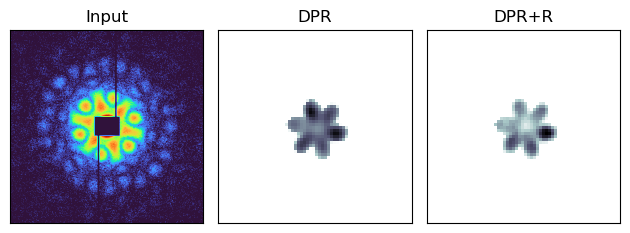

In [7]:
plt.figure()
for i in range(N):
    plt.subplot(i + 1, 3, 1)
    plt.imshow(torch.log10(1 + inputs[i, 0, :, :]), cmap='turbo', vmin=0)
    plt.xticks([])
    plt.yticks([])
    plt.title('Input')
    plt.subplot(i + 1, 3, 2)
    plt.imshow(outputs[i, 0, :, :].detach(), cmap='bone_r', vmin=0, vmax=outputs[i].max())
    plt.xticks([])
    plt.yticks([])
    plt.title('DPR')
    plt.subplot(i + 1, 3, 3)
    plt.imshow(outputs[i, 1, :, :].detach(), cmap='bone_r', vmin=0, vmax=outputs[i].max())
    plt.xticks([])
    plt.yticks([])
    plt.title('DPR+R')
plt.tight_layout()
plt.show()